# Trabalho 2

## Nome:
### Leonardo Ishida - 12873424
### Isaac Harim Ribeiro Rosendo - 13673235

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import math
import requests
import cv2 # trata cor como BGR em vez de RGB
from PIL import Image

##Exercício 1

###A) Método de Francis

Método de Francis

O Método de Francis, é um procedimento iterativo utilizado para calcular os **autovalores** de uma matriz quadrada. Ele é especialmente útil para matrizes grandes e é considerado um dos métodos mais eficientes e numericamente estáveis para este propósito.

O método de Francis funciona da seguinte maneira:
<br> <br>

Decomposição- (QR): No começo de cada iteração, decompõe-se a matriz AA na forma de um produto de uma matriz ortogonal $QQ$ e uma matriz triangular superior $RR$ , ou seja:
$$
A=QR
$$

<br> <br>
Atualização da Matriz: Atualiza-se a matriz AA, como: $$A′=RQ$$ E a nova matriz $A′A′$ tem os mesmos autovalores que a matriz original AA.

<br> <br>
Convergência: O critério de parada é baseado no erro, que pode ser definido como o maior valor absoluto das entradas abaixo da diagonal principal da matriz $AA$, e também com um $Kmax: 1000$ limitando o numero de iterações por a matriz ser muito grande.

In [ ]:
def francis(A, tol):
    n = A.shape[0]
    autovetores = np.eye(n)
    erro = np.inf
    max_iter = 1000
    iter_count = 0

    while erro > tol and iter_count < max_iter:
        Q, R = np.linalg.qr(A)
        A = R @ Q
        autovetores = autovetores @ Q
        erro = np.max(np.abs(np.tril(A, -1)))
        iter_count += 1

    autovalores = np.diag(A)
    return autovalores, autovetores

### B) retorne a decomposição SVD de uma matriz qualquer $A_{m×n}$

A Decomposição SVD tem diversas aplicações, mas para ilustrar melhor o seu poder iremos utilizar para comprimir imagens. Ao manter apenas os valores singulares mais significativos, é possível reconstruir a imagem de forma aproximada, mas com um tamanho de arquivo muito menor.
<br>
No código abaixo iremos implementar a decomposição SVD com duas condições a primeira é usando apenas o *método de Francis uma vez*, e a segunda será usando uma abordagem condicional baseada nas dimensões da matriz $A_{mxn}$ , sendo caso 1 $m <= n$ e caso 2 $m > n$, detalhando o código abaixo:
<br><br>
####Caso 1: $ m $>$ n $


1. Chamamos o método de francis recebendo os autovalores em auto e autovetores na matriz U, todos esses valores tem origem da matriz $AA^T$.
$$auto,U=francis(AA^T,tol)$$


2. Para o cáculo dos valores singulares devemos tirar as raízes quadradas dos autovalores não negativos.
$$S=\sqrt{auto}$$


3. Vamos construir a matriz de S.
$$S_{matrix}=diag(S)$$

4. Já tendo U e S, apenas para completar o SVD precisamos calcular o V. Aqui, V é calculado multiplicando AT pelos autovetores U e depois pela inversa da matriz diagonal dos valores singulares.
$$V=(A^TU)⋅S_{matrix}^{-1}$$



<br><br>
####Caso 2 : $ m $<=$ n $

1. Chamamos o método de francis recebendo os autovalores em auto e autovetores na matriz U, todos esses valores tem origem da matriz $A^TA$
$$auto,V=francis(A^TA,tol)$$


2. Para o cáculo dos valores singulares devemos tirar as raízes quadradas dos autovalores não negativos.
$$S=\sqrt{auto}$$


3. Vamos construir a matriz de S.
$$S_{matrix}=diag(S)$$

4. Já tendo V e S, apenas para completar o SVD precisamos calcular o U. Já nesta parte do código, U é calculado multiplicando A pelos autovetores V e depois pela inversa da matriz diagonal dos valores singulares..
$$U=(AV)⋅S_{matrix}^{-1}$$

In [ ]:
def my_svd(A):
    tol = 1e-5
    m, n = A.shape

    if(m > n):

      # Método de Francis aplicado em A @ A.T para obter V e os autovalores
      auto, U = francis(A @ A.T, tol)

      # Os valores singulares são as raízes quadradas dos autovalores não negativos
      S = np.sqrt(np.abs(auto))

      # Construir a matriz S com os valores singulares
      S_matrix = np.diag(S)

      # calculo do V
      V = (A.T @ U) @ np.linalg.inv(S_matrix)


    else:
      # Método de Francis aplicado em A.T @ A para obter V e os autovalores
      auto, V = francis(A.T @ A, tol)

      # Os valores singulares são as raízes quadradas dos autovalores não negativos
      S = np.sqrt(np.abs(auto))

      # Construir a matriz S com os valores singulares
      S_matrix = np.diag(S)

      # calculo do U
      U = A @ V @ np.linalg.inv(S_matrix)



    return U, S, V.T

### C) Comprimindo imagem

#####Impriminto imagem original

A imagem é carregada em A a partir do arquivo "cat.png". Em seguida, ela é convertida para tons de cinza utilizando o espaço de cores BGR, pois muitas aplicações de processamento de imagem, é útil trabalhar com imagens em escala de cinza, onde cada pixel é representado por um único valor que representa a intensidade de luminosidade, **simplificando a análise e reduzindo a complexidade computacional**, pois há apenas um canal de informação em vez de três. Após isso a imagem resultante será mostrada com a escala de cinza, sem exibir os eixos e com um título "Imagem Original".

(-0.5, 323.5, 323.5, -0.5)

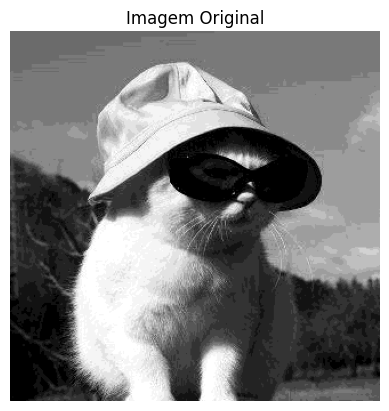

In [ ]:
A = plt.imread("cat.png")

# Converter a imagem para tons de cinza
A_normalizada = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)


# Mostra a imagem original
plt.figure()
plt.imshow(A_normalizada, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')

##### Comprimindo Imagem usando o SVD implementado na questão anterior

Ao utilizar a função SVD personalizada para comprimir uma imagem, observamos que uma compressão de 70% e 50% demorou aproximadamente 50 segundos. Esse tempo indica que, embora a função tenha sido eficaz em reduzir a dimensão dos dados, ela possui um custo computacional elevado. A compressão mais agressiva de 50% resultou em uma maior perda de qualidade de imagem em comparação com a compressão de 70%.

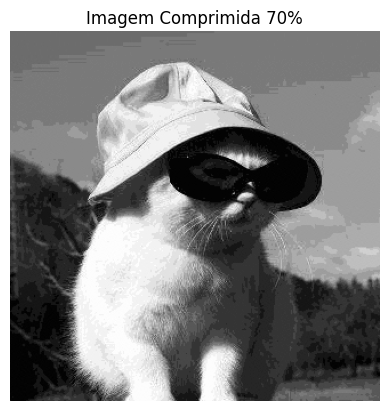

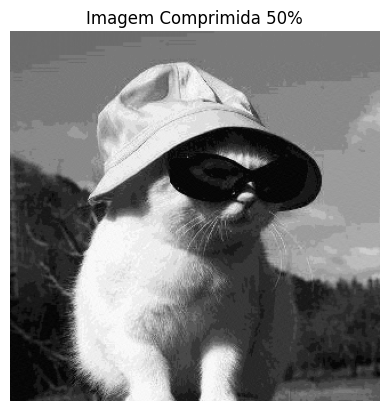

In [ ]:
# valores ficarem entre 0 e 1
A_normalizada = A_normalizada.astype(np.double)

# Calcula a decomposição SVD
U, S, V = my_svd(A_normalizada)

compres = int(np.ceil(0.7 * len(S)))

Ak = U[:, :compres] @ np.diag(S[:compres]) @ V[:compres, :]

# saida da img
# Mostra a imagem comprimida
plt.figure()
plt.imshow(Ak, cmap='gray')
plt.title('Imagem Comprimida 70%')
plt.axis('off')
plt.show()

compres = int(np.ceil(0.5 * len(S)))

Ak = U[:, :compres] @ np.diag(S[:compres]) @ V[:compres, :]

# saida da img
# Mostra a imagem comprimida
plt.figure()
plt.imshow(Ak, cmap='gray')
plt.title('Imagem Comprimida 50%')
plt.axis('off')
plt.show()

##### Comprimindo Imagem usando a função linalg.svd

Utilizando a função linalg.svd da biblioteca NumPy para comprimir uma imagem, verificamos que uma compressão de 70% e 50% levou cerca de 5 segundos. Esse tempo consideravelmente menor demonstra a eficiência da implementação otimizada da biblioteca NumPy. A compressão mais agressiva de 50% também resultou em uma perda maior de detalhes da imagem em relação à compressão de 70%, mas a diferença de qualidade se manteve dentro de um intervalo aceitável, evidenciando a eficácia e rapidez da função linalg.svd na manipulação e redução de dados.

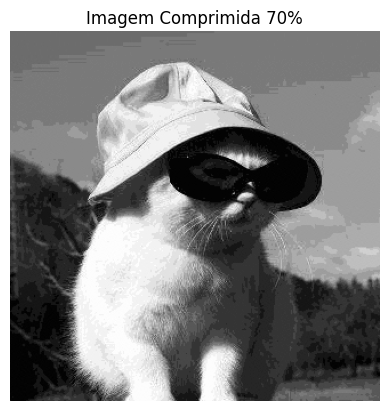

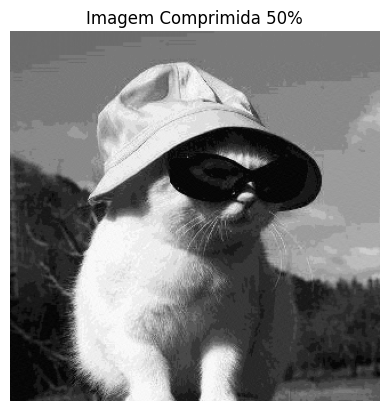

In [ ]:
# valores ficarem entre 0 e 1
A_normalizada = A_normalizada.astype(np.double)

# Calcula a decomposição SVD
U, S, V = np.linalg.svd(A_normalizada)

compres = int(np.ceil(0.7 * len(S)))

Ak = U[:, :compres] @ np.diag(S[:compres]) @ V[:compres, :]

# saida da img
# Mostra a imagem comprimida
plt.figure()
plt.imshow(Ak, cmap='gray')
plt.title('Imagem Comprimida 70%')
plt.axis('off')
plt.show()

compres = int(np.ceil(0.5 * len(S)))

Ak = U[:, :compres] @ np.diag(S[:compres]) @ V[:compres, :]

# saida da img
# Mostra a imagem comprimida
plt.figure()
plt.imshow(Ak, cmap='gray')
plt.title('Imagem Comprimida 50%')
plt.axis('off')
plt.show()

Comparando os dois métodos de compressão de imagem utilizando SVD, observamos diferenças significativas tanto no tempo de processamento quanto na eficiência. A função SVD personalizada levou cerca de 50 segundos para comprimir a imagem em 70% e 50%, enquanto a função linalg.svd da biblioteca NumPy realizou a mesma tarefa em aproximadamente 5 segundos. Isso mostra que a linalg.svd é muito mais rápida e eficiente. Em termos de compressão, ambas as técnicas alcançaram reduções de 70% e 50%, porém, o método da NumPy oferece uma vantagem clara em termos de desempenho computacional, permitindo uma compressão rápida sem comprometer significativamente a qualidade da imagem.

##Exercício 2

### A)

## Lagrange

O polinômio de lagrange é dado por:
$$ P_n(x) = y_0 l_0(x) + y_1 l_1(x) + ... + y_n l_n(x) = \sum_{k=0}^n y_k l_k(x) $$   onde, $l_k(x)$ são polinômios também e tem a forma:   
$$\ell_k(x) = \prod_{\substack{i=0\\ i \ne k}}^n \frac{x - x_i}{x_k - x_i},   k = 0, \dots, n$$.

In [ ]:
# Função que calcula o valor de yp, o valor da interpolação do ponto xp
# Nesse caso, temos que calcular o polinômio inteiro para calcular um valor de yp

def interpol_lagrange(xi, yi, xp):
    m = np.shape(xi)[0] # obtendo o tamanho do vetor de pontos
    yp = 0

    # laço para iterar sobre os n-1 polinômios li de lagrange
    for i in range(m):
        p = 1

        # calculando li
        for j in range(m):
            if i != j: # evitar de dividir por 0
                p = p * (xp - xi[j]) / (xi[i] - xi[j])

        # somando o valor de cada li aplicado no ponto
        yp = yp + p * yi[i]

    return yp

## Newton

A forma de calcular o polinômio de Newton é diferente, temos:  
$$P_n(x) = a_0 + a_1(x - x_0) + a_2 (x - x_0)(x - x_1) + \dots  
+ a_n (x - x_0) (x - x_1) \dots (x - x_{n-1})$$
E cada coeficiente $α$ é calculado utilizando diferenças divididas, utilizando a equação:
$$a_k = f[x_0, x_1, ..., x_k],  k = 0, 1, ..., n$$.

In [ ]:
# Função que calcula o valor de yp, o valor da interpolação do ponto xp
# Nesse caso, temos que calcular todas as diferenças divididas para calcular um valor de yp

def interpol_newton(xi, yi, xp):
    n = np.shape(xi)[0]

    # criando uma matriz auxiliar para calcular as diferenças divididas
    aux = np.zeros((n, n))
    aux[:, 0] = yi

    for i in range(1, n):
        for j in range(n - i):

            # calculando as diferenças dividias da coluna anterior
            aux[j][i] = (aux[j][i-1] - aux[j+1][i-1]) / (xi[j]-xi[i+j])

    # calculando a interpolação
    soma = aux[0][0]
    for i in range(1, n):
        produto = 1
        for j in range(i):
            produto = produto * (xp - xi[j]) # calculando os produtos (x-x0)(x-x1)

        #  acumulando o valor da interpolação no ponto xp
        soma = soma + (produto * aux[0][i])

    return soma


### B)

Abaixo, estamos definindo algumas variáveis que serão úteis ao longo do exercício, como 11 e 21 pontos igualmente espaçados no intervalo $[-1,1]$, a função do problema $f(x) = 1/(1+25x^2)$ e os pontos que vamos utilizar para interpolar

In [ ]:
intervalo = np.array([-1, 1])
x11 = np.linspace(-1, 1, num=11)
x21 = np.linspace(-1, 1, num=21)

funcao = lambda x: 1/(1 + 25*x**2)

x_grafico = np.linspace(-1, 1, num=101)
y_grafico = funcao(x_grafico)

Agora, vamos calcular a interpolação de lagrange utilizando 11 pontos e, em seguida, iremos plotar o gráfico do resultado junto com funcao que foi dada para uma melhor visualização do resultado

In [ ]:
y11 = funcao(x11)
y_lagrange11 = interpol_lagrange(x11, y11, x_grafico)

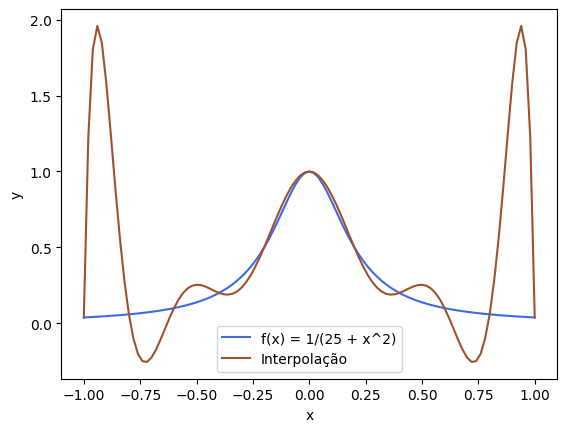

In [ ]:
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x_grafico, y_grafico, color='royalblue', label='f(x) = 1/(25 + x^2)')
plt.plot(x_grafico, y_lagrange11, color='sienna', label='Interpolação')
plt.legend()
plt.show()

Vamos também calcular a interpolação utilizando o método de Newton, plotar o gráfico e comparar com a função original

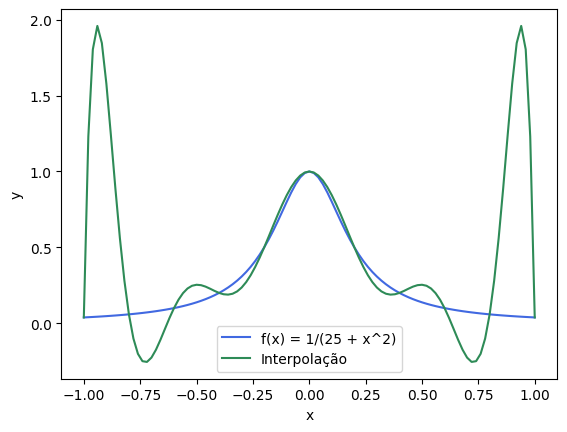

In [ ]:
y_newton11 = interpol_newton(x11, y11, x_grafico)

plt.plot(x_grafico, y_grafico, color='royalblue', label='f(x) = 1/(25 + x^2)')
plt.plot(x_grafico, y_newton11, color='seagreen', label='Interpolação')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Vamos analisar os resultados   
Primeiramente, vemos que os resultados obtidos pela interpolação de lagrange e de newton são idênticos, isso acontece por causa do teorema que afirma que para $n+1$ pontos $(x_i, y_i)$, existe apenas um único polinômio que satisfaz $y_i = P_n(x_i), i=0, ..., n$.   Para provar, vamos utilizar:
$$ P_n(x) = a_0 + a_1x + a_2x^2 + ··· + a_nx^n = y_i$$
Também podemos reescrever na forma matricial para facilitar os cálculos
$$\begin{bmatrix} 1 & x_0 & x_0^2 & \dots & x_0^n \\ 1 & x_1 & x_1^2 & \dots & x_1^n \\ 1 & x_2 & x_2^2 & \dots & x_2^n \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_n & x_n^2 & \dots & x_n^n \end{bmatrix} \begin{bmatrix} a_0 \\ a_1 \\ a_2 \\ \vdots \\ a_n \end{bmatrix} = \begin{bmatrix} y_0 \\ y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}$$
Se calcularmos o determinante da matriz que contém os $x_s$ e for diferente de 0, então o sistema possui solução única, o que garante um polinômio único.    
Outrossim, vale ressaltar que o método de newton pode ser mais eficiente quando vamos adicionar pontos para fazer a interpolação, pois não é necessário recalcular tudo, apenas as diferenças dividias que sofreram mudanças por causa da adição de pontos.  
Partindo para análise do gráfico, percebemos que os resultados obtidos não são satifatórios, principalmente nos extremos do intervalo, isso ocorre por causa do fenômeno de Rounge, que tem 2 causas: grau muito alto do polinômio e pontos igualmente espaçados.   
Primeiramente, vamos examinar o grau do polinômio. Como estamos, inicialmente, fazendo a interpolação com 11 pontos, vamos obter um polinômio de grau 10, então, e, como nos extremos os valores no eixo x são maiores, há uma possibilidade maior da função "ir para baixo" ou "para cima" muito rapidamente, causando distorções na interpolação.   
Agora, verificando os pontos igualmente espaçados. Esse fator contribui negativamente para a nossa interpoalação, pois ao utilizar pontos igualmente espaçados, forçamos o polinômio a passar em todos os pontos, o que faz com que o polinômio tenha que fazer grandes oscilações para atender esse requisito, pricipalmente nos extremos do intervalo.

### C)

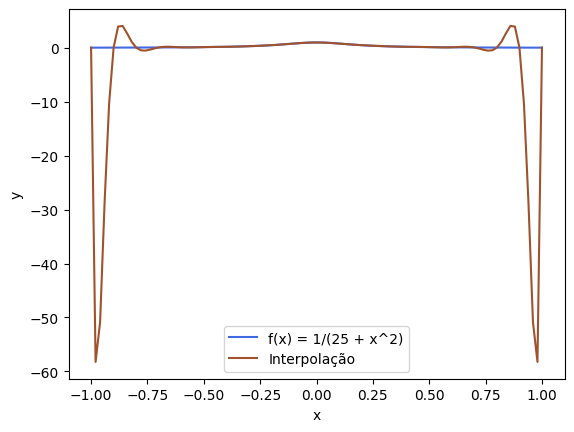

In [ ]:
y21 = funcao(x21)
y_lagrange21 = interpol_lagrange(x21, y21, x_grafico)

plt.plot(x_grafico, y_grafico, color='royalblue', label='f(x) = 1/(25 + x^2)')
plt.plot(x_grafico, y_lagrange21, color='sienna', label='Interpolação')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

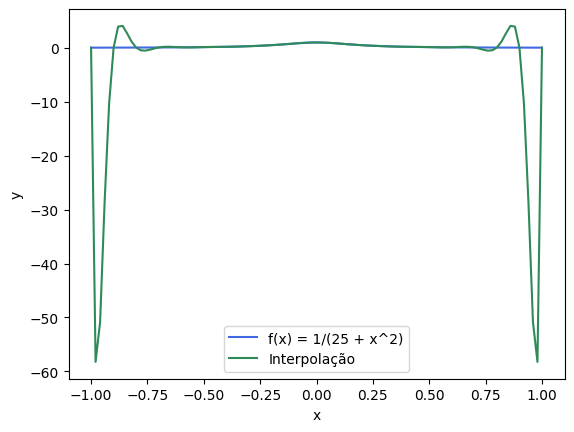

In [ ]:
y_newton21 = interpol_newton(x21, y21, x_grafico)
plt.plot(x_grafico, y_grafico, color='royalblue', label='f(x) = 1/(25 + x^2)')
plt.plot(x_grafico, y_newton21, color='seagreen', label='Interpolação')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

Como é possível observar, os resultados obtidos na interpolação ficaram piores. Isso ocorre porque o fenômeno de runge fica ainda mais agravado, pois aumentamos o grau do polinômio interpolador e ainda continuamos utilizando pontos igualmente espaçados. Ou seja, não resolvemos o problema anterior do item B, apenas agravamos os erros.

### D)

Vamos resolver o problema da interpolação utilizando splines, ou seja, vamos solucionar o fenômeno de Runge utilizando uma interpolação por partes.   
O objetivo é utilizar várias funções $S_k(x)$, onde k é o grau do função, que atenda os seguinte requisitos:   
$S_{k,i} = S_k|_{[x_i,x_{i+1}]}$, com $i = 0,...,n-1$, é um polinômio de grau $k$;

$S_k \in C^{k-1}([a,b])$; (A função final, que consiste na junção de todas as splines, é contínua)

$S_k(x_i) = y_i$, com $i = 0,...,n$. (A spline no ponto xi coincide com a função que queremos interpolar)

Primeiramente, vamos utilizar splines de uma dimensão, ou seja, vamos usar retas para fazer a interpolação.   
$S_{1,i}(x) = y_i \frac{x_{i+1}-x}{x_{i+1}-x_i} + y_{i+1} \frac{x-x_i}{x_{i+1}-x_i}$, $x \in [x_i,x_{i+1}]$, $i = 0,...,n-1$.

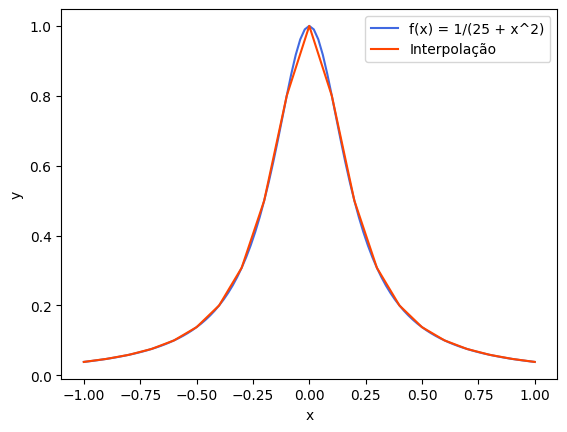

In [ ]:
# funcao interp1d retorna uma funcao que calcula para cada novo ponto um valor de interpolação (S1,i(x))
f = interp1d(x21, y21)
y_spline1d_21 = f(x_grafico)

# plot dos gráficos
plt.plot(x_grafico, y_grafico, color='royalblue', label='f(x) = 1/(25 + x^2)')
plt.plot(x_grafico, y_spline1d_21, color='orangered', label='Interpolação')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

Agora, vamos utilizar funções de grau 3 nas splines, ou seja, vamos obter uma aproximação melhor do que a spline de 1 grau, pois uma spline de grau 3 apresenta continuidade nas primeiras e segundas derivadas, o que garante uma maior suavidade nas curvas.   
$S_{3,i}(x) = a_i(x-x_i)^3 + b_i(x-x_i)^2 + c_i(x-x_i) + d_i$, $i = 0,...,n-1$.

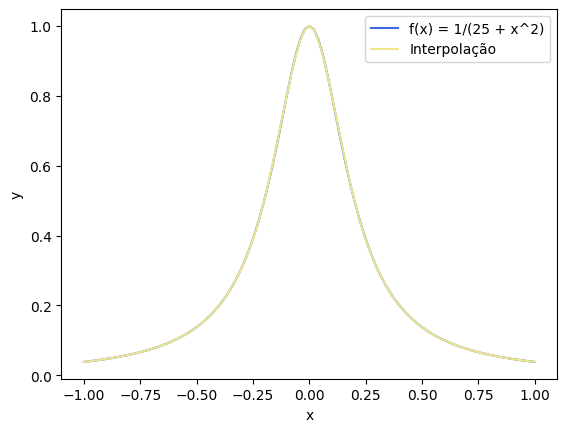

In [ ]:
# funcao interp1d retorna uma funcao que calcula para cada novo ponto um valor de interpolação (S3,i(x))
f = interp1d(x21, y21, kind='cubic')
y_interp3d_21 = f(x_grafico)

# plot dos gráficos
plt.plot(x_grafico, y_grafico, color='royalblue', label='f(x) = 1/(25 + x^2)')
plt.plot(x_grafico, y_interp3d_21, color='khaki', label='Interpolação')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

### E)

Vamos calcular os nós de Chebychev utilizando a equação abaixo para obter os pontos no eixo x que oferecem a melhor interpolação $$x_i = \frac{a+b}{2} + \frac{b-a}{2} \cos \left( \frac{2i+1}{2(n+1)} \pi \right),  i=0,...,n$$

In [ ]:
def calcula_nos(a, b, n):
    i = np.arange(0, n)
    return (a+b) * 0.5 + (b-a) * 0.5 * np.cos((2 * i[:] + 1) * np.pi / (2 * (n + 1)))

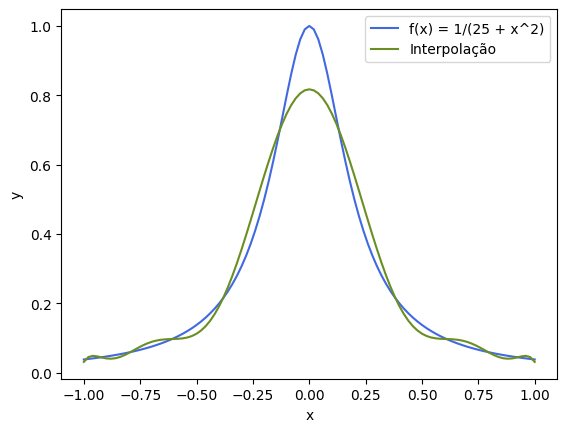

In [ ]:
# 11 pontos chebychev lagrange

# utilziando a fórmula do nós de chebychev
x_chebychev11 = calcula_nos(intervalo[0], intervalo[1], 11)

# obtendo o valor da função em cada nó de chebychev
y_chebychev11 = funcao(x_chebychev11[:])

# fazendo a interpolação
y_lagrange_cheby11 = interpol_lagrange(x_chebychev11, y_chebychev11, x_grafico)

# plot dos gráficos
plt.plot(x_grafico, y_grafico, color='royalblue', label='f(x) = 1/(25 + x^2)')
plt.plot(x_grafico, y_lagrange_cheby11, color='olivedrab', label='Interpolação')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

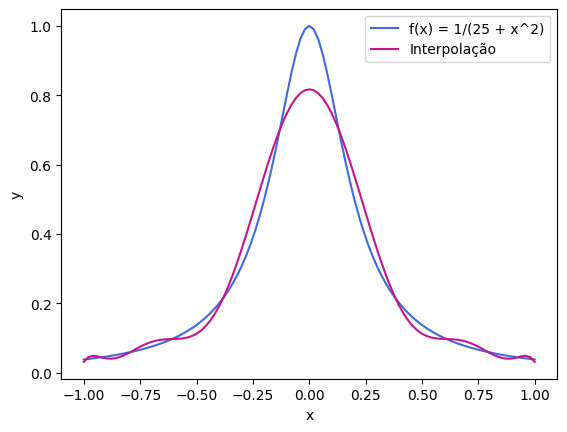

In [ ]:
# 11 pontos chebychev newton

# fazendo a interpolação, não é necessário recalcular os nós de chebychev
y_newton_cheby11 = interpol_newton(x_chebychev11, y_chebychev11, x_grafico)

# plot dos gráficos
plt.plot(x_grafico, y_grafico, color='royalblue', label='f(x) = 1/(25 + x^2)')
plt.plot(x_grafico, y_newton_cheby11, color='mediumvioletred', label='Interpolação')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

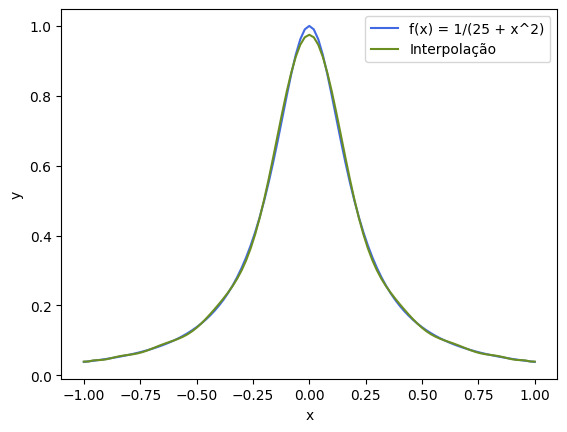

In [ ]:
# 21 pontos chebichev lagrange

# utilziando a fórmula do nós de chebychev
x_chebychev21 = calcula_nos(intervalo[0], intervalo[1], 21)

# calculando os valores da função em cada nó
y_chebychev21 = funcao(x_chebychev21[:])

# aplicando a interpolação de lagrange
y_lagrange_cheby21 = interpol_lagrange(x_chebychev21, y_chebychev21, x_grafico)

# plot dos gráficos
plt.plot(x_grafico, y_grafico, color='royalblue', label='f(x) = 1/(25 + x^2)')
plt.plot(x_grafico, y_lagrange_cheby21, color='olivedrab', label='Interpolação')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

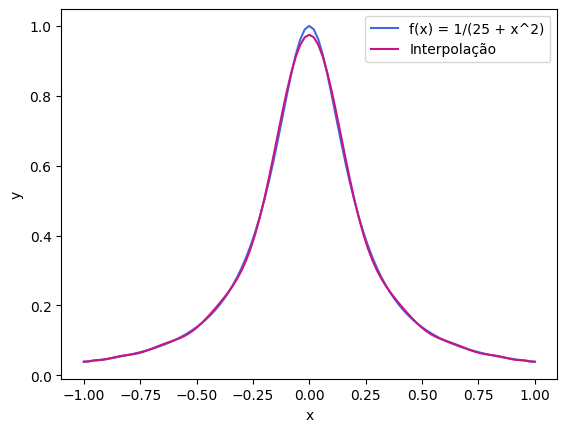

In [ ]:
# 21 pontos chebichev newton

# fazendo a interpolação com os 21 nós de chebychev
y_newton_cheby21 = interpol_newton(x_chebychev21, y_chebychev21, x_grafico)

# plot dos gráficos
plt.plot(x_grafico, y_grafico, color='royalblue', label='f(x) = 1/(25 + x^2)')
plt.plot(x_grafico, y_newton_cheby21, color='mediumvioletred', label='Interpolação')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()

Conforme é possível observar nos gráficos gerados, os resultados foram muito satisfatórios, não obtivemos as distorções nos extremos que as interpolações de lagrange e newton apresentaram com pontos igualmente espaçados.   Esse resultado foi possível porque nós de chebychev garantem uma distribuição não uniforme de pontos, e sim uma distribuição com maior densidade de pontos nos extremos, o que faz com que a variação nas extremidades do polinômio seja controlado, pois o ajuste que o polinômio tem que fazer para passar nos pontos $(xi,yi)$, é menor. Ou seja, ao utilizar nós de chebychev, reduzimos o fenômeno de Runge.

## Exercício 3

###A)
   

Para a função mmq ela realiza o ajuste de curvas utilizando o método dos mínimos quadrados (MMQ), usando um polinômio de grau $k − 1$ aos dados fornecidos e retorna os coeficientes do polinômio que minimizam o erro quadrático entre os valores ajustados e os dados observados. São feitos com os seguintes passos:

<br>
1. Constroi a matriz de X
<br>
2. Faz a formação do sistema normal:
$$A = X^TX$$
$$b = X^Ty$$
<br>
3. Resolve o sistema linear
$$ a = A^{-1}b$$

In [ ]:
def mmq(x,y,k):
    X = np.vander(x,k)
    A = np.transpose(X).dot(X)
    b = np.transpose(X).dot(y)
    a = np.linalg.solve(A,b)
    return a

O código seguinte ao contrário do outro ajusta um polinômio de grau $k − 1$ aos dados fornecidos, utilizando a **decomposição QR** para melhorar a estabilidade numérica do ajuste, e retorna os coeficientes do polinômio que minimizam o erro quadrático entre os valores ajustados e os dados observados.São feitos com os seguintes passos:
<br>
1. Construção da Matriz X
2. Decomposição QR
<br>Q é uma matriz ortogonal e R triangular superior.
$$X=QR$$
<br>
3. Forma o sistema
 $$Q^Ty=b$$
<br>
4. resolve o sistema triangular superior
$$a = R^{-1}b$$

In [ ]:
def mmqQR(x,y,k):
    X=np.vander(x,k)
    (Q,R)=np.linalg.qr(X)
    b=np.transpose(Q).dot(y)
    a=np.linalg.solve(R,b)
    return a

Ambos os códigos tem a mesma finalidade, porém oque diferem eles é:
<br> <br>

Estabilidade Numérica: onde o primeiro código a solução direta do sistema normal $$ A⋅a = b$$ pode ser numericamente instável, especialmente se a matriz [XX] for mal condicionada, resultando em **perdas de precisão**. Já o segundo com a decomposição QR **melhora a estabilidade numérica**, mantendo a precisão melhor do que a multiplicação direta das matrizes como em mmq.
<br> <br>

Complexidade Computacional: Na mmq pode ser **menos eficiente** devido à necessidade de calcular produtos de **matrizes grandes**. Apesar da decomposição QR ser computacionalmente intensiva, ela pode ser **mais eficiente e confiável para grandes conjuntos de dados ou matrizes mal condicionadas**.

### B)  
Primeiramente, vamos ler os dados do arquivo e trata-los de forma que podemos utiliza-los ao decorrer do nosso código

In [ ]:
def plot_graficos(num_dias, y_mmq, y_real):
    plt.figure(figsize=(13, 5))
    plt.plot(num_dias, y_mmq, color='teal', label='Função de aproximação')
    plt.plot(num_dias, y_real, color='crimson', label='Dados acumulados')

    plt.xlabel('Dia')
    plt.ylabel('Num de casos')
    plt.legend()

    plt.show()

In [ ]:
with open('casosacumuladosbrasilatuaizado.txt', 'r') as f:
    dados_acumulados_str = f.read()

    # Transformando os dados que estão em formato de texto em uma lista de números inteiros
    dados_acumulados = list(map(int, filter(None, dados_acumulados_str.split('\n'))))

    # Contando quantos dias estão presente em nossos dados
    numero_dias = list(range(1, len(dados_acumulados)+1))

Agora, como nossa função que queremos aproximar tem forma $ f(x) = ab^x $, ou seja, não é uma função linear, temos que realizar a linearização.   
Para fazer esse processo, vamos linearizar utilizando logaritmo, então vamos obter a seguinte função:
$$ \ln(f(x)) = \ln(a) + x \cdot \ln(b) $$
$$ F(x) = 1 \cdot \alpha_0 +  \phi_1 \cdot \alpha_1 $$   
Dessa forma, podemos utilizar a função fornecida MMQ para calcular os $\alpha s$, e assim gerar nosso polinômio aproximador.   
Então, o primeiro passo é aplicar o logaritmo natural em $f(x)$


In [ ]:
ln_fx = list(map(np.log, dados_acumulados))

Depois, podemos aplicar o método dos mínimos quadrados, utilizando $ln(f(x))$ para obter os coeficientes $\alpha$   
Como visto na equação acima, os coeficientes $a$ e $b$ estão dentro de uma função função logaritmíca, então precisamos utilizar a função exponencial para desfazer a linearização da função

In [ ]:
def calcula_coeficientes(num_dias, dados, k):
    alfas = mmq(num_dias, dados, k)
    return np.exp(alfas)

In [ ]:
b, a = calcula_coeficientes(numero_dias, ln_fx, 2)
b, a

(1.1113520177397234, 31.77484809447941)

In [ ]:
fx = lambda x: a * (b ** x)

y_mmq = fx(numero_dias[:])

Vamos plotar os dois gráficos e comparar o resultado obtido pelo método dos mínimos quadrados

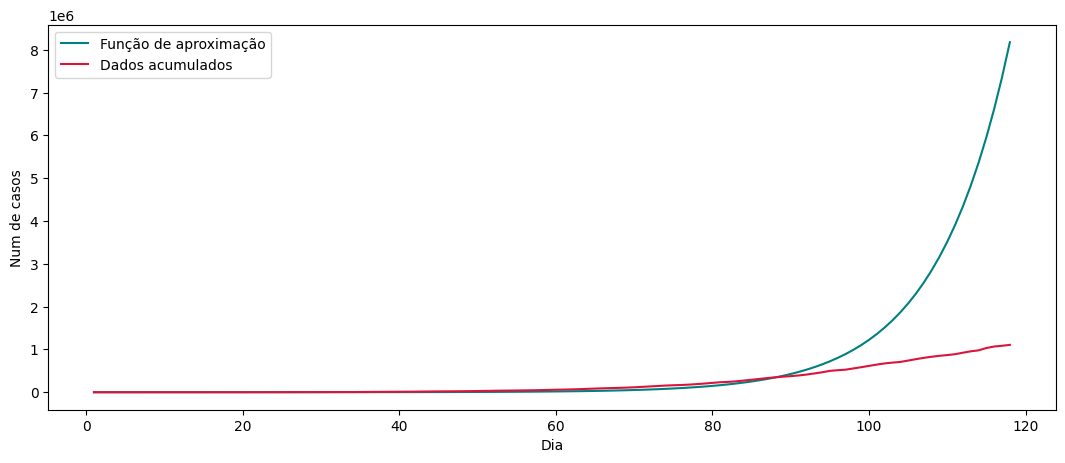

In [ ]:
plot_graficos(numero_dias, y_mmq, dados_acumulados)

### C)

Para realizar o exercício, vamos ter que recalcular os coeficientes $a$ e $b$, utilizando os primeiros 20 pontos, e definir a nova função $f(x) = ab^x$

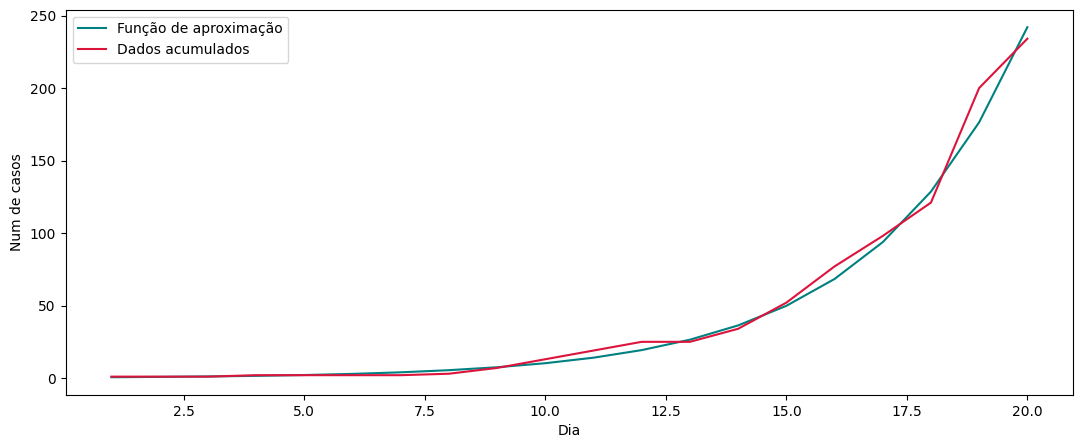

In [ ]:
b20, a20 = calcula_coeficientes(numero_dias[:20], ln_fx[:20], 2)
fx20 = lambda x: a20 * (b20 ** x)

y_mmq20 = fx20(numero_dias[:20])
plot_graficos(numero_dias[:20], y_mmq20, dados_acumulados[:20])

### D)

Vamos repetir o processo do item B, utilizando os últimos 50 pontos

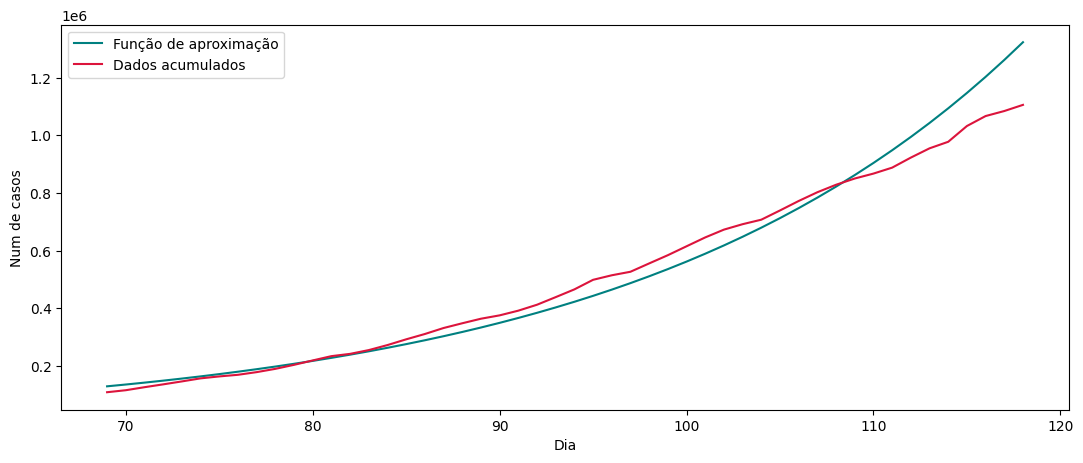

In [ ]:
b50, a50 = calcula_coeficientes(numero_dias[-50:], ln_fx[-50:], 2)
fx50 = lambda x: a50 * (b50 ** x)

y_mmq50 = fx50(numero_dias[-50:])
plot_graficos(numero_dias[-50:], y_mmq50, dados_acumulados[-50:])

### E)

Vamos analisar item por item.

Começando pelo item B, percebemos que a aproximação para os dados da covid nos primeiros dias estão bem coerentes com os dados reais. Porém, a partir do dia 90, aproximadamente, percebemos que os dados reais não estão mais condizentes com a nossa aproximação. Isso aconteceu porque, depois do agravamento da pandemia, medidas sanitárias para o controle e combate da doença foram implementadas, como distanciamento social, uso de máscaras, etc. o que resultou em uma queda na taxa de infecção e nos casos confirmados. Dessa forma, os dados reais não seguem uma função exponencial durante todo o período reportado, logo, aproximar os dados utilizando $f(x) = ab^x$ não é a malhor escolha considerando todo o período.

Analisando o item C, percebe-se uma boa aproximação de $f(x)$ dos dados reais, isso porque no começo da pandemia, medidas para tentar diminuir a transmisão da covid ainda não tinham sido adotadas, logo, a tendência era que os casos da doença crescessem de forma exponencial, então nossa aproximação pelos mínimos quadrados faz sentido e condiz com a realidade esperada para a época.

Partindo para o item D, percebemos que, novamente, obtemos uma boa aproximação, mas não tão boa quanto no item C. Isso acontece porque ao utilizar o método dos mínimos quadrados temos a garantia de estar obtendo a melhor aproximação utilizando $f(x)$, dessa maneira, mesmo que os dados reais não cresçam de forma exponencial, ainda conseguimos obter uma boa aproximação e também porque estamos analisando um intervalo não muito grande, ou seja, obtemos uma boa aproximação local.
